In [ ]:
# Command to use with Google Colab
# !gsutil -m cp -r "gs://butqdb-1.0.0.physionet.org" "."
# !mv "/content/butqdb-1.0.0.physionet.org" "/content/aura-data"
# !ln -s "/content/aura-data" "../aura-data"

In [ ]:
# Install package 
# !pip install scaleogram wfdb mat4py
# !pip install tensorflow
# !pip install keras

In [1]:
%matplotlib inline

# Preprocessing libs
import sys
import time
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import wfdb
import re
#from tqdm import tqdm
from tqdm.notebook import tqdm

# Display
pd.set_option("display.max_columns", 50)
import warnings
warnings.filterwarnings('ignore')

# Math, signal libs
import pywt
import scaleogram as scg 
from mat4py import loadmat
from scipy.fftpack import fft, ifft
from math import *

# ML libs
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Read source for create a dataset of annotations
As inputs we have : 
- Signal frequence is 1000Hz so we have 1000 records per seconds
- 18 patients with 24H records per patient
- df_data : signal records data from .dat file (list of 90 millions records)
- df_annotation : labels quality class from .csv file (1, 2 or 3; 0 means the quality was not annotated in this segment) 
- Source : https://physionet.org/content/butqdb/1.0.0/

-> At first step, we will take we will take data only from the 111001 patient which seems to have the best balance of data in each class

## Analysis with patient 111001

- The signal frequence is 1000Hz, so we have 1000 records per seconds
- The average ECG period is 1 second
- We choice to split the dataset in records of 2 seconds partitions
- So the dataset will have 2000 features which is the value of the signal in period of 2 seconds
- The 2001th feature of our dataset will be the label of our signal (value extract from the final label feature in the annotation file)
- In order to low the data loaded in RAM and speed the model training, we will reduce the signal length frequence from 1000Hz to 250Hz (so to take one 1 in 8 in our 2 seconds period, we will check after if this method doesn't bias the model training)

In [2]:
# Read the file path we have in the current folder 

# Save image path of training data
import pathlib 
file_paths = pathlib.Path('../aura-data')

# Convert all paths into a string with comprehension list
file_paths = [str(file_path) for file_path in list(file_paths.glob("*/*"))] # list python files in the directory tree
print(file_paths[:5])
# Select dat_path_file for patients 111001, 100001, 105001
r = re.compile(".*(111001|100001|105001)_ECG\.dat$") # create regex to match ECG.dat files
ecg_file_dat_paths = list(filter(r.match, file_paths)) # Filter only paths for .dat files
print(ecg_file_dat_paths[:5])
# Select csv_path_file for patients 111001, 100001, 105001
r = re.compile(".*(111001|100001|105001)_ANN\.csv$") # create regex to match ECG.dat files
ecg_file_csv_paths = list(filter(r.match, file_paths)) # Filter only paths for .dat files
print(ecg_file_csv_paths[:5])
# Create list of patient ids for patients 111001, 100001, 105001
r = re.compile(".*(111001|100001|105001)")
folder_paths = pathlib.Path('../aura-data')
patient_ids = [str(folder_name) for folder_name in list(folder_paths.iterdir()) if folder_name.is_dir()] # extract folder paths in the current directory
patient_ids = list(filter(r.findall, patient_ids))
patient_ids = [re.findall('\d+', x )[0] for x in patient_ids]
patient_ids

['../aura-data/118001/118001_ECG.hea', '../aura-data/118001/118001_ACC.hea', '../aura-data/118001/118001_ANN.csv', '../aura-data/118001/118001_ACC.dat', '../aura-data/118001/118001_ECG.dat']
['../aura-data/100001/100001_ECG.dat', '../aura-data/111001/111001_ECG.dat', '../aura-data/105001/105001_ECG.dat']
['../aura-data/100001/100001_ANN.csv', '../aura-data/111001/111001_ANN.csv', '../aura-data/105001/105001_ANN.csv']


['100001', '111001', '105001']

In [3]:
def resampling_data(sample_size, dat_file_path, csv_file_path):
    # Import csv annotation file and remove lines with null start/ end/ class values
    header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
    df_csv = pd.read_csv(csv_file_path, names=header_list)
    df_csv = df_csv[df_csv["class"].notnull() & df_csv["start"].notnull() & df_csv["end"].notnull()]
    df_csv["start"] = df_csv["start"].astype(int)
    df_csv["end"] = df_csv["end"].astype(int)
    df_csv["class"] = df_csv["class"].astype(int)
    df_csv = df_csv[df_csv["class"]!=0].reset_index(drop=True)
    df_csv['signal_length']=df_csv['end'] - df_csv['start'] 
    #df_csv["sample"]=round(df_csv["signal_length"]/sample_size)+1
    display(df_csv.head())
    display(df_csv.tail())
    display(df_csv["class"].value_counts()/len(df_csv))

    # Import data and reshape it to array matrix with 1000 features 
    # Import all data in array
    arr_data = wfdb.rdrecord(dat_file_path.replace(".dat",""))
    arr_data = arr_data.adc()
    display(f"Input dat file size : {arr_data.shape}")

    # Create a second column to set label value
    arr_zero = np.zeros((arr_data.shape[0],arr_data.shape[1]), dtype=int)
    arr_data = np.append(arr_data, arr_zero, axis=1)

    # Create list with class label for each range of 1000 values
    arr_data[0,1] = df_csv["class"][0]
    for i in tqdm(range(0,len(df_csv))):
        label = df_csv["class"][i]
        start = int(df_csv.start[i])
        end = int(df_csv.end[i])
        for ii in range(start, end):
            arr_data[ii,1] = label

    # Display the number of row with null label
    display(f"Number of element with label == 0 : {arr_data[arr_data[:,1]==0].shape[0]}")

    # Remove row with null label
    # arr_data = arr_data[arr_data[:,1]!=0]
    # need to have number of rows which is a multiple of sample_size
    arr_data_size = (arr_data.shape[0]//sample_size)*sample_size

    # Reshape vector data into 2 Matrix (values, labels)
    arr_data_values = arr_data[:,0]
    arr_data_labels = arr_data[:,1]
    arr_data_values = arr_data_values[:arr_data_size].reshape(arr_data[:arr_data_size].shape[0]//sample_size,sample_size)
    arr_data_labels = arr_data_labels[:arr_data_size].reshape(arr_data[:arr_data_size].shape[0]//sample_size,sample_size)

    # Choose the mode as final label for each sample
    arr_data_label_results = np.zeros((arr_data_labels.shape[0],1), dtype=int)
    for i in range(len(arr_data_labels)):
        arr_data_label_results[i]=stats.mode(arr_data_labels[i])[0]

    # Concatenate data array matrix with label column vector array
    arr_data_resampled = np.concatenate((arr_data_values,arr_data_label_results), axis=1)

    # Remove rows with null element in label column
    arr_data_resampled = arr_data_resampled[arr_data_resampled[:,sample_size]!=0]
    display(f"Final array size : {arr_data_resampled.shape}")
    return arr_data_resampled

In [4]:
def prepare_class(sample_size, arr_data_all, resample_scale):
    arr_class_1 = arr_data_all[arr_data_all[:,sample_size]==1][:,:sample_size:resample_scale]
    arr_class_1 = arr_class_1#/1000
    display(arr_class_1.shape)
    np.random.shuffle(arr_class_1)
    display(arr_class_1)
    arr_class_2 = arr_data_all[arr_data_all[:,sample_size]==2][:,:sample_size:resample_scale]
    arr_class_2 = arr_class_2#/1000
    #display(arr_class_2.shape)
    np.random.shuffle(arr_class_2)
    #display(arr_class_2)
    arr_class_3 = arr_data_all[arr_data_all[:,sample_size]==3][:,:sample_size:resample_scale]
    arr_class_3 = arr_class_3#/1000
    #display(arr_class_3.shape)
    np.random.shuffle(arr_class_3)
    #display(arr_class_3)
    arr_class_0 = np.concatenate((arr_class_2, arr_class_3), axis=0) 
    display(arr_class_0.shape)
    np.random.shuffle(arr_class_0)
    display(arr_class_0)
    return arr_class_0, arr_class_1

In [5]:
# Use function for all patients 
sample_size = 2000
arr_data_all = np.zeros((0,sample_size+1), dtype=int)
for patient_id, dat_file_path, csv_file_path in zip(patient_ids, ecg_file_dat_paths,ecg_file_csv_paths):
    display(f"patient id : {patient_id}")
    arr_data_labelized = resampling_data(sample_size, dat_file_path, csv_file_path)
    arr_data_all = np.concatenate((arr_data_all,arr_data_labelized), axis=0)
arr_data_all

'patient id : 100001'

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
0,1.0,198867.0,2.0,1.0,19525.0,1.0,1,7047,2,1,7047,2,7046
1,198868.0,320282.0,1.0,19526.0,28694.0,2.0,7048,17209,1,7048,17209,1,10161
2,320283.0,373109.0,2.0,28695.0,32739.0,1.0,17210,28390,2,17210,28694,2,11484
3,373110.0,2197974.0,1.0,32740.0,96699.0,2.0,28391,32653,1,28695,32653,1,3958
4,2197975.0,2582746.0,2.0,96700.0,110564.0,1.0,32654,71061,2,32654,112474,2,79820


,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
758,NaN,NaN,NaN,NaN,NaN,NaN,59818365,59824575,1,86486096,86580752,2,94656
759,NaN,NaN,NaN,NaN,NaN,NaN,59824576,59826028,2,86580753,86588415,1,7662
760,NaN,NaN,NaN,NaN,NaN,NaN,59826029,59830915,1,86588416,86757975,2,169559
761,NaN,NaN,NaN,NaN,NaN,NaN,59830916,59832492,2,86757976,86827127,1,69151
762,NaN,NaN,NaN,NaN,NaN,NaN,59832493,59858995,1,86827128,87087000,2,259872


2    0.500655
1    0.496723
3    0.002621
Name: class, dtype: float64

'Input dat file size : (87087000, 1)'

'Number of element with label == 0 : 762'

'Final array size : (43543, 2001)'

'patient id : 111001'

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
0,1.0,4315694.0,2.0,1.0,411254.0,2.0,1,7523,1,1,415143,2,415142
1,4315695.0,4334794.0,1.0,411255.0,421291.0,1.0,7524,16977,2,415144,421291,1,6147
2,4334795.0,7908996.0,2.0,421292.0,433271.0,2.0,16978,18848,1,421292,433515,2,12223
3,7908997.0,7915643.0,1.0,433272.0,447315.0,1.0,18849,105566,2,433516,447315,1,13799
4,7915644.0,13719093.0,2.0,447316.0,451027.0,2.0,105567,108563,1,447316,451027,2,3711


,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
2734,NaN,NaN,NaN,NaN,NaN,NaN,35206925,35212255,1,88835329,88857959,1,22630
2735,NaN,NaN,NaN,NaN,NaN,NaN,35212256,35217108,2,88857960,89860280,2,1002320
2736,NaN,NaN,NaN,NaN,NaN,NaN,35217109,35222483,1,89860281,89872911,1,12630
2737,NaN,NaN,NaN,NaN,NaN,NaN,35222484,35270820,2,89872912,90622551,2,749639
2738,NaN,NaN,NaN,NaN,NaN,NaN,35270821,35273851,1,90622552,90645000,3,22448


2    0.495071
1    0.396130
3    0.108799
Name: class, dtype: float64

'Input dat file size : (90645000, 1)'

'Number of element with label == 0 : 2738'

'Final array size : (45322, 2001)'

'patient id : 105001'

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
0,1.0,47323379.0,3.0,1.0,47323871.0,3.0,1,47323500,3,1,47323500,3,47323499
1,47323380.0,47388207.0,2.0,47323872.0,47329547.0,1.0,47323501,47323539,1,47323501,47326788,2,3287
2,47388208.0,47404719.0,1.0,47329548.0,47333899.0,2.0,47323540,47326788,2,47326789,47329547,1,2758
3,47404720.0,47449035.0,2.0,47333900.0,47370615.0,1.0,47326789,47329715,1,47329548,47333904,2,4356
4,47449036.0,47492819.0,1.0,47370616.0,47377747.0,2.0,47329716,47333904,2,47333905,47370615,1,36710


,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
1349,NaN,NaN,NaN,NaN,NaN,NaN,79063217,79158543,1,138907088,138909568,2,2480
1350,NaN,NaN,NaN,NaN,NaN,NaN,79158544,79159920,2,138909569,138989087,1,79518
1351,NaN,NaN,NaN,NaN,NaN,NaN,79159921,79163967,1,138989088,138997600,2,8512
1352,NaN,NaN,NaN,NaN,NaN,NaN,79163968,79166160,2,138997601,139120079,1,122478
1353,NaN,NaN,NaN,NaN,NaN,NaN,79166161,79174599,1,139120080,139147000,3,26920


2    0.499261
1    0.499261
3    0.001477
Name: class, dtype: float64

'Input dat file size : (139147000, 1)'

'Number of element with label == 0 : 1353'

'Final array size : (69573, 2001)'

array([[32292, 32270, 32272, ..., 15422, 15422,     2],
       [15450, 15486, 15498, ...,  6051,  6037,     2],
       [ 6019,  5995,  5957, ..., -1206, -1200,     2],
       ...,
       [  -77,  -323,  -441, ...,  -293,  -516,     3],
       [ -530,  -615,  -661, ...,  -529,  -540,     3],
       [ -698,  -817,  -845, ...,   133,   -72,     3]])

In [7]:
arr_data_all.shape

(158438, 2001)

In [8]:
resample_scale = 8
arr_class_0, arr_class_1 = prepare_class(sample_size, arr_data_all, resample_scale)

(78077, 250)

array([[-11891, -11827, -11831, ..., -12084, -12160, -12028],
       [  -181,   -195,   -200, ...,   -171,   -229,   -274],
       [  -117,   -112,   -119, ...,   -172,   -170,   -168],
       ...,
       [-13230, -13324, -13382, ..., -13308, -13330, -13318],
       [-12531, -12543, -12519, ..., -12342, -12370, -12382],
       [    46,     68,     98, ...,    232,    271,    312]])

(80361, 250)

array([[   18,   -13,   -24, ...,   -10,    -3,   -12],
       [   89,   116,   136, ...,  -254,   -44,   180],
       [    0,   -41,    19, ...,     1,   -19,    14],
       ...,
       [-1436, -1563, -1343, ...,    20,    -3,   -39],
       [   60,    73,    81, ...,     9,    14,    21],
       [ 2167,  1718,    54, ..., -1505, -1416, -1654]])

## Analysis Wavelet Transformation & Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


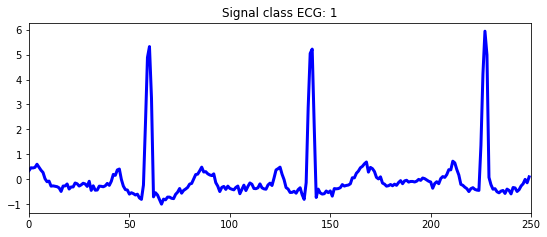

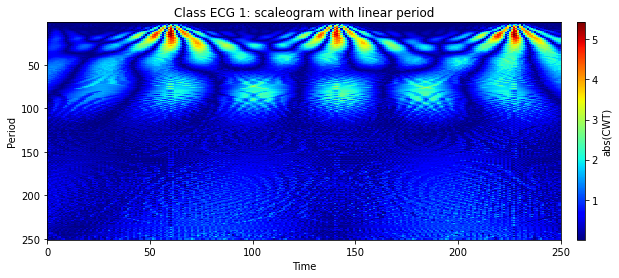

In [14]:
# Display Scaleogram of signal labelled in class 1
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = np.random.randint(0,len(arr_class_1))
data = arr_class_1[0]
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(250,) # apply standard scalar in the signal
data = list(data)
label = 1

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


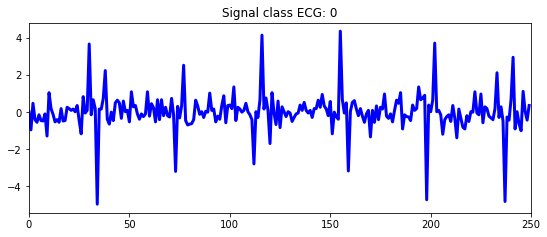

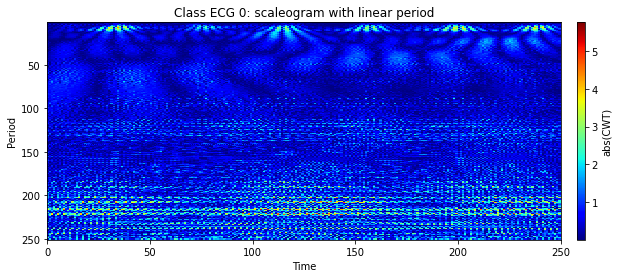

In [17]:
# Display Scaleogram of signal labelled in class 1
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = np.random.randint(0,len(arr_class_1))
data = arr_class_0[2]
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(250,) # apply standard scalar in the signal
data = list(data)
label = 0

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    

# Create model classification prediction

## 1- Preprocessing train & test data

In [22]:
# Convert array into list to train our model
arr_class_0_flatten = list(arr_class_0)
arr_class_1_flatten = list(arr_class_1)
# Reduce samples data for each class to reduce_size
reduce_size = 1500
full_1500 = (arr_class_0_flatten[0:reduce_size] + arr_class_1_flatten[0:reduce_size])

# create the data set with scaleogramme image for each signal data
# We create a X_full 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

start_time = time.time()

fs = len(full_1500[0])
# sgn_length = 1000   #65536   Pay atention with ram memory! 
size_dataset = len(full_1500)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))

for i in tqdm(range(0, size_dataset)):
    if i % 500 == 0:
        print (i, 'done!')
    signal = full_1500[i]
    scaler = StandardScaler()
    signal = scaler.fit_transform(signal.reshape(-1, 1)).reshape(250,) # apply standard scalar in the signal
    signal = list(signal)
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    for j in range(0, 3):
        X_full[i, :, :, j] = coeff[:,:fs-1]

end_time = time.time()

print(f"Time spent : {end_time - start_time} seconds")
print(f" X_full dimension : {X_full.shape}")

# Create label encoder
list_labels_class_0 = ['0']*reduce_size 
list_labels_class_1 = ['1']*reduce_size 
list_labels = (list_labels_class_0 + list_labels_class_1)

le = preprocessing.LabelEncoder()
list_labels_encoded = le.fit_transform(list_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, list_labels_encoded, test_size=0.25, random_state=42)
print(f" X_train dimension : {X_train.shape}")

0 done!
500 done!
1000 done!
1500 done!
2000 done!
2500 done!

Time spent : 138.36646604537964 seconds
 X_full dimension : (3000, 249, 249, 3)
 X_train dimension : (2250, 249, 249, 3)


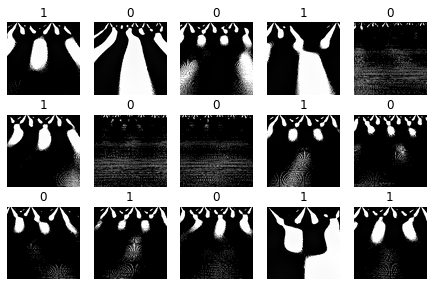

In [24]:
#Inspecting DATA that we will give as input for the model
n_rows = 3
n_cols = 5
class_names = ['0', '1']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

## 2- Train & test CNN model

In [30]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[249, 249, 3]), #-> output matrix 249 x 249 x 3
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"), #-> output matrix 16 x 16 x 32
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"), #-> output matrix 8 x 8 x 64
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(), # -> 1024
    tf.keras.layers.Dense(units=64, activation='relu'), #-> 64
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"), #-> 32
    tf.keras.layers.Dense(units=16, activation ="relu"), #-> 16
    tf.keras.layers.Dense(units=2, activation='softmax') #-> 2
])

In [32]:
# Create a schedule learning rate
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

In [33]:
# Create a compiler
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 249, 249, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [45]:
# Train the model with training and validation data - first try
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
71/71 [==============================] - 98s 1s/step - loss: 0.4092 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.7640
Epoch 2/5
71/71 [==============================] - 97s 1s/step - loss: 0.3607 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.4186 - val_sparse_categorical_accuracy: 0.8013
Epoch 3/5
71/71 [==============================] - 90s 1s/step - loss: 0.3509 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.3975 - val_sparse_categorical_accuracy: 0.8147
Epoch 4/5
71/71 [==============================] - 84s 1s/step - loss: 0.3178 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3929 - val_sparse_categorical_accuracy: 0.8107
Epoch 5/5
71/71 [==============================] - 98s 1s/step - loss: 0.2865 - sparse_categorical_accuracy: 0.8707 - val_loss: 0.4173 - val_sparse_categorical_accuracy: 0.8053


In [46]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 8s 330ms/step - loss: 0.4173 - sparse_categorical_accuracy: 0.8053


[0.41726920008659363, 0.8053333163261414]

In [47]:
#print(history.history.keys())

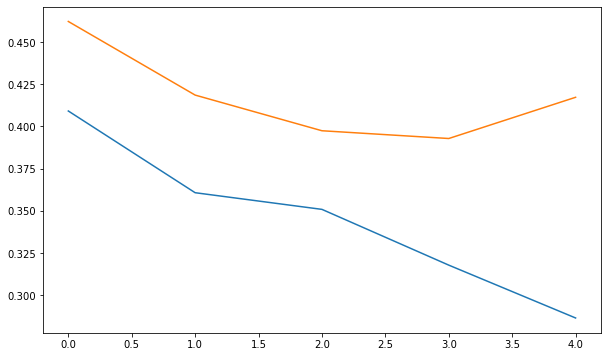

In [48]:
plt.figure(figsize = (10,6))
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss)
plt.plot(val_loss)

In [38]:
"""
fig = px.line(y=history.history["loss"], color=px.Constant("Training loss"), title=f"Loss variation for CNN with {len(full_1500)} images",labels=dict(x="Epochs", y="Loss rate", color="Legend")) # 
fig.add_scatter(y=history.history["val_loss"], name="Validation loss")
fig.show()
"""

'\nfig = px.line(y=history.history["loss"], color=px.Constant("Training loss"), title=f"Loss variation for CNN with {len(full_1500)} images",labels=dict(x="Epochs", y="Loss rate", color="Legend")) # \nfig.add_scatter(y=history.history["val_loss"], name="Validation loss")\nfig.show()\n'

In [49]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('Figure_epochs.png')   
    plt.close()

In [40]:
plot_learning_curves(history)

In [50]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [51]:
# Confusion Matrix With Scikit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Text(189.2400000000001, 0.5, 'True')

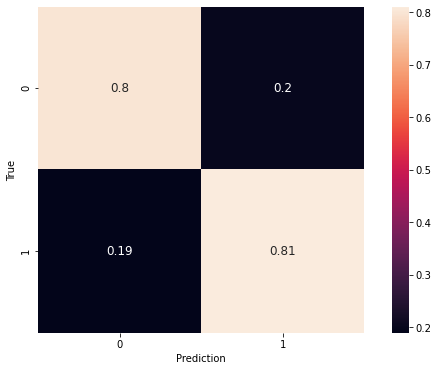

In [52]:
# Ploting Confusion Matrix

df_cm = pd.DataFrame(cm_norm, ['0', '1'], ['0', '1'])
plt.figure(figsize = (10,6))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')

In [44]:
"""
fig = px.imshow(df_cm)
fig.show()
"""

'\nfig = px.imshow(df_cm)\nfig.show()\n'

In [36]:
# Save trained CNN model
model.save("CNN_model_all_patients")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN_model_all_patients/assets


In [34]:
#model = keras.models.load_model('CNN_model')

## 3- Test the CNN model with data production => to fix

In [ ]:
# Reconstruct my CNN model
# reconstructed_model = keras.models.load_model("CNN_model")

In [142]:
# Create reduced samples data for each class to production_size for production
production_size = 100
# full_prod = (arr_class_1_flatten[reduce_size:reduce_size+production_size] + arr_class_2_flatten[reduce_size:reduce_size+production_size] + arr_class_3_flatten[reduce_size:reduce_size+production_size])
full_prod = (arr_class_1_flatten[-production_size:] + arr_class_2_flatten[-production_size:] + arr_class_3_flatten[-production_size:])


In [143]:
# Test with production values : create X_prod as input production datas
fs = len(full_prod[0])
# sgn_length = 1000   #65536   Pay atention with ram memory! 
size_dataset = len(full_prod)
scales = range(1, fs)
waveletname = 'morl'
 
X_prod = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in tqdm(range(0, size_dataset)):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_prod[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_prod[i, :, :, j] = coeff[:,:fs-1]

0 done!



In [85]:
# Test model usage for classification prediction in production
# model.predict_classes(X_prod)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 0, 1, 1, 2])

In [146]:
X_prod[0,:,:,:].shape

(249, 249, 3)

In [96]:
model.predict_proba(X_prod[0,:,:,:])

ValueError: in user code:

    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 249, 3]


In [144]:
# Create label encoder for production tests
list_labels_class_1_prod = ['1']*production_size 
list_labels_class_2_prod = ['2']*production_size 
list_labels_class_3_prod = ['3']*production_size 
list_labels_prod = (list_labels_class_1_prod + list_labels_class_2_prod + list_labels_class_3_prod)

le = preprocessing.LabelEncoder()
list_labels_encoded_prod = le.fit_transform(list_labels_prod)

In [145]:
model.evaluate(X_prod, list_labels_encoded_prod)

10/10 [==============================] - 5s 512ms/step - loss: 0.8035 - sparse_categorical_accuracy: 0.7300


[0.8034822344779968, 0.7300000190734863]